## Создание системы прогнозирования неблагоприятных погодных условий

#### Импортируем библиотеки для последующей работы 

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from statsmodels.tsa.stattools import adfuller
from IPython.display import Image, display 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
import torch, torchvision
from torch import nn

In [8]:
df = pd.read_csv('atlantic.csv')

#### Смотрим на колонки нашего датасета и на тип данных, которые они содержат

In [9]:
df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  int64 
 17  Moderate Win

In [21]:
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [22]:
df.head(10)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851-06-25,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,1851-06-25,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,1851-06-25,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,1851-06-25,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,1851-06-25,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
5,AL011851,UNNAMED,1851-06-26,0,,HU,28.2N,97.0W,70,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
6,AL011851,UNNAMED,1851-06-26,600,,TS,28.3N,97.6W,60,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
7,AL011851,UNNAMED,1851-06-26,1200,,TS,28.4N,98.3W,60,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
8,AL011851,UNNAMED,1851-06-26,1800,,TS,28.6N,98.9W,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
9,AL011851,UNNAMED,1851-06-27,0,,TS,29.0N,99.4W,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  int64 
 17  Moderate Win

In [12]:
df.isnull().sum()

ID                  0
Name                0
Date                0
Time                0
Event               0
Status              0
Latitude            0
Longitude           0
Maximum Wind        0
Minimum Pressure    0
Low Wind NE         0
Low Wind SE         0
Low Wind SW         0
Low Wind NW         0
Moderate Wind NE    0
Moderate Wind SE    0
Moderate Wind SW    0
Moderate Wind NW    0
High Wind NE        0
High Wind SE        0
High Wind SW        0
High Wind NW        0
dtype: int64

In [13]:
df

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0


In [14]:
df.describe()

,Date,Time,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,4.910500e+04,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000
mean,1.949802e+07,910.125975,52.005091,-251.406496,-868.671031,-869.315772,-872.676428,-871.409245,-875.570940,-875.765319,-876.682028,-876.323205,-877.564321,-877.655045,-877.923552,-877.786295
std,4.461850e+05,671.043363,27.681902,964.313907,353.299666,351.548910,342.153768,345.628984,333.651396,333.133376,330.526085,331.535176,328.027275,327.774794,327.021430,327.408253
min,1.851062e+07,0.000000,-99.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,1.911110e+07,600.000000,35.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
50%,1.956093e+07,1200.000000,45.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
75%,1.989081e+07,1800.000000,70.000000,990.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
max,2.015111e+07,2330.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


In [15]:
df.shape

(49105, 22)

In [16]:
df[df.duplicated() == True]

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW


In [17]:
df.Event.unique()

array(['  ', ' L', ' R', ' I', ' P', ' W', ' C', ' S', ' G', ' T'],
      dtype=object)

#### Колонка "Event" описание:

1) L - Landfall (the wind center crosses a major coastline) (попадание на сушу (центр ветра пересекает крупное побережье))
2) W - Maximum sustained wind speed for storm history (максимальная устойчивая скорость ветра за всю историю шторма)
3) P - Minimum central pressure for storm history (минимальное центральное давление за всю историю шторма)
4) I - Intensity peak for storm history in terms of both pressure and wind (пик интенсивности шторма за всю историю в терминах давления и ветра)
5) C - Closest approach to coast not followed by a landfall (ближайший подход к берегу, не сопровождаемый попаданием на сушу)
6) S - Status change in the system (изменение статуса системы)
7) G - Genesis of the system (генезис системы)
8) T - An additional fix point added to clarify track detail (дополнительная точка фиксации, добавленная для уточнения деталей трека)

In [18]:
df.Status.unique()

array([' HU', ' TS', ' EX', ' TD', ' LO', ' DB', ' SD', ' SS', ' WV'],
      dtype=object)

#### Колонка "Status" описание:

1) WV - Tropical Wave (Тропическая волна - разновидность области низкого атмосферного давления, вытянутая область относительно низкого давления воздуха, ориентированная с севера на юг, которая перемещается с востока на запад через тропики, вызывая собой районы облачности и грозы)

2) TD - Tropical Depression (Тропическая депрессия - область пониженного давления внутри тропиков с силой ветра менее 6 баллов Бофорта (27 узлов), обычно с одной или немногими замкнутыми изобарами или даже без замкнутых изобар)

3) TS - Tropical Storm (Тропический шторм - тип циклона, или погодной системы низкого давления, которая возникает над тёплой морской поверхностью и сопровождается мощными грозами, выпадением ливневых осадков и ветрами штормовой силы)

4) HU - Hurricane (Ураган)

5) EX - Extratropical cyclone (Экстра-тропический циклон -  это области низкого давления , которые вместе с антициклонами из областей высокого давления влияют на погоду на большей части Земля. Внетропические циклоны способны вызывать что угодно: от облачности и умеренных ливней до сильных штормов , гроз , метелей , и торнадо . Эти типы циклонов определяются как крупномасштабные (синоптические) погодные системы низкого давления , которые возникают в средних широтах Земли. В отличие от тропических циклонов , внетропические циклоны вызывают быстрые изменения температуры и точки росы вдоль широких линий, называемых погодными фронтами , около центра циклона)


6) SD - Subtropical depression (winds < 34 kt) (Субтропический шторм (ветер < 34 узла))


7) SS - Subtropical storm (winds >34 kt) (Субтропический шторм (ветер >34 узла))
8) LO - A low pressure system not fitting any of above descriptions (система низкого давления, не подходящая под любое из вышеописанных описаний)

9) DB - non-tropical Disturbance not have a closed circulation (не тропическое возмущение, не имеющее закрытого циркуляции)

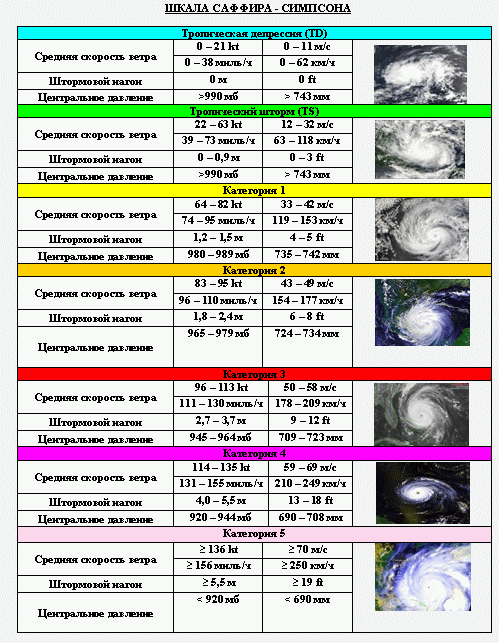

In [19]:
storms_explanation = Image(filename='storms.gif')

display(storms_explanation)

Text(0.5, 1.0, 'Частота циклонов в месяц.')

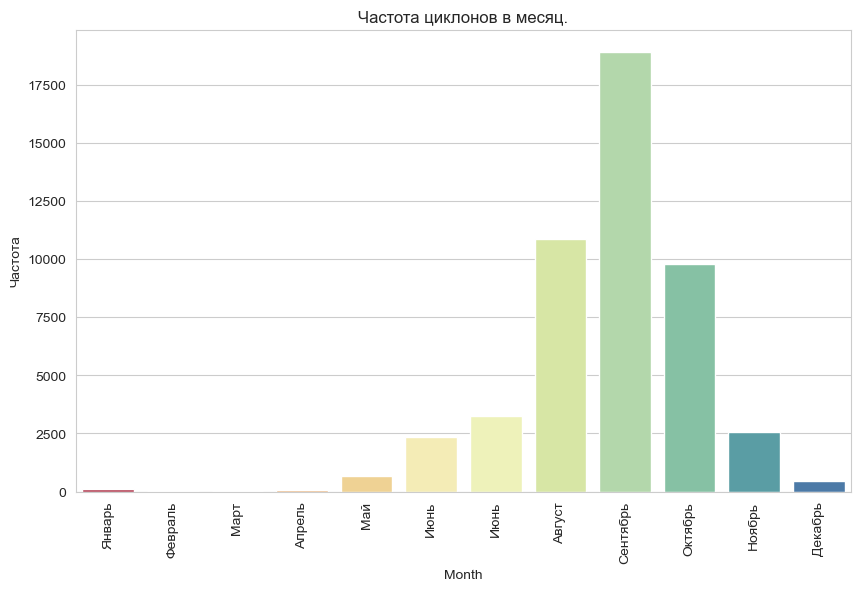

In [23]:
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Year'] = df['Date'].apply(lambda x: x.year)
mnt = ['Январь' , 'Февраль' , 'Март' , 'Апрель' , 'Май' , 'Июнь' , 'Июнь' , 'Август' , 'Сентябрь','Октябрь' , 'Ноябрь' , 'Декабрь']
temp = df.groupby('Month').count()
temp = temp.sort_values(by = 'Month' , ascending = False)
plt.figure(figsize = (10,6))
sns.set_style("whitegrid")
ax = sns.barplot(x = temp.index , y = 'Date' , data=temp , palette = 'Spectral' )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11] , mnt , rotation = 90)
plt.ylabel('Частота')
plt.title('Частота циклонов в месяц.')

In [24]:
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1]=="W":
        coord *= -1
    if x[-1]=="S":
        coord *= -1
    return coord

df["Latitude"] = df["Latitude"].apply(coordinate_mapping)
df["Longitude"] = df["Longitude"].apply(coordinate_mapping)

In [31]:
df

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,00:00:00,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,06:00:00,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,12:00:00,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,18:00:00,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,21:00:00,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,12:00:00,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,18:00:00,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,00:00:00,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,06:00:00,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0


In [34]:
df = pd.read_csv('atlantic.csv')

In [35]:
df["Date"] = df["Date"].astype("object")
for i, date_str in enumerate(df["Date"].unique()):
    df.loc[df["Date"]==date_str, "Date"] = f"{str(date_str)[0:4]}-{str(date_str)[4:6]}-{str(date_str)[6:]}"

In [36]:
df["Time"] = df["Time"].astype("object")
time_replace = [str(x) for x in df["Time"].unique()]
for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, "0")
    time_replace[i] = f"{time_replace[i][0:2]}:{time_replace[i][2:4]}:00"
for old, new in zip(df["Time"].unique(), time_replace):
    df.loc[df["Time"]==old, "Time"] = new

In [37]:
df["Datetime"] = df["Date"]+" "+df["Time"]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.drop(columns=["Date", "Time"], inplace=True)
df.sort_values(by=["Datetime"], inplace=True)

In [41]:
df = df.set_index('Datetime')

In [38]:
number_of_storms={}
count = df['Datetime'].dt.year.value_counts()

count_df = pd.DataFrame(count)
count_df = count_df.reset_index()
count_df

,Datetime,count
0,2005,907
1,1995,767
2,1933,696
3,1969,686
4,2010,663
...,...,...
160,1925,69
161,1864,67
162,1854,60
163,1855,35


In [42]:
data = pd.DataFrame(df.resample('M').count()['Minimum Pressure'])

C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


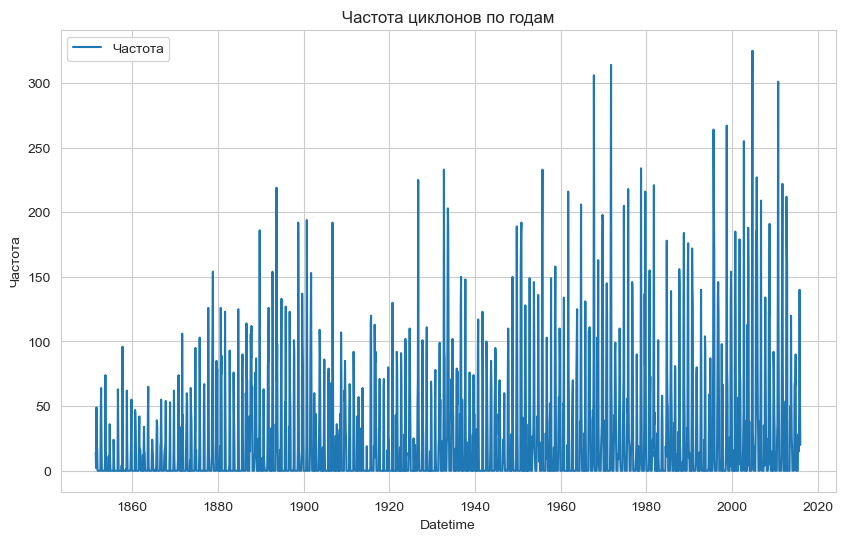

In [44]:
plt.figure(figsize= (10,6))
sns.lineplot(x = data.index, y = 'Minimum Pressure' , data = data , label = 'Частота')
plt.ylabel('Частота')
plt.title('Частота циклонов по годам')
plt.show()

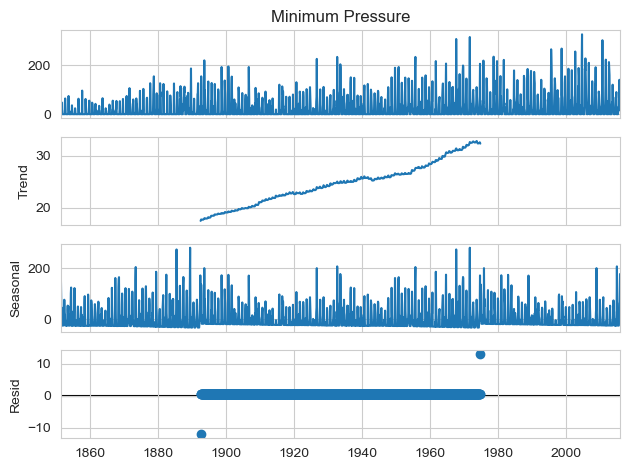

In [49]:
decomposition = sm.tsa.seasonal_decompose(data.squeeze(), model='additive', period = len(data.squeeze())//2)
fig = decomposition.plot()

In [50]:
data_boxcox = pd.Series(boxcox(data['Minimum Pressure'], lmbda=0), index = data.index)

In [51]:
data_boxcox

Datetime
1851-06-30    2.639057
1851-07-31    0.693147
1851-08-31    3.891820
1851-09-30    2.772589
1851-10-31    2.833213
                ...   
2015-07-31    2.708050
2015-08-31    4.007333
2015-09-30    4.941642
2015-10-31    4.077537
2015-11-30    2.995732
Freq: M, Length: 1974, dtype: float64

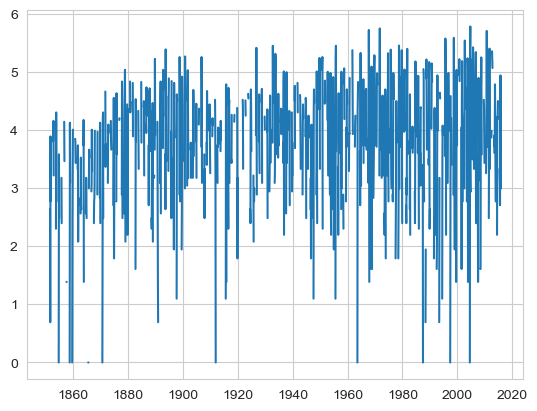

In [52]:

plt.plot(data_boxcox, label='After Box Cox tranformation')

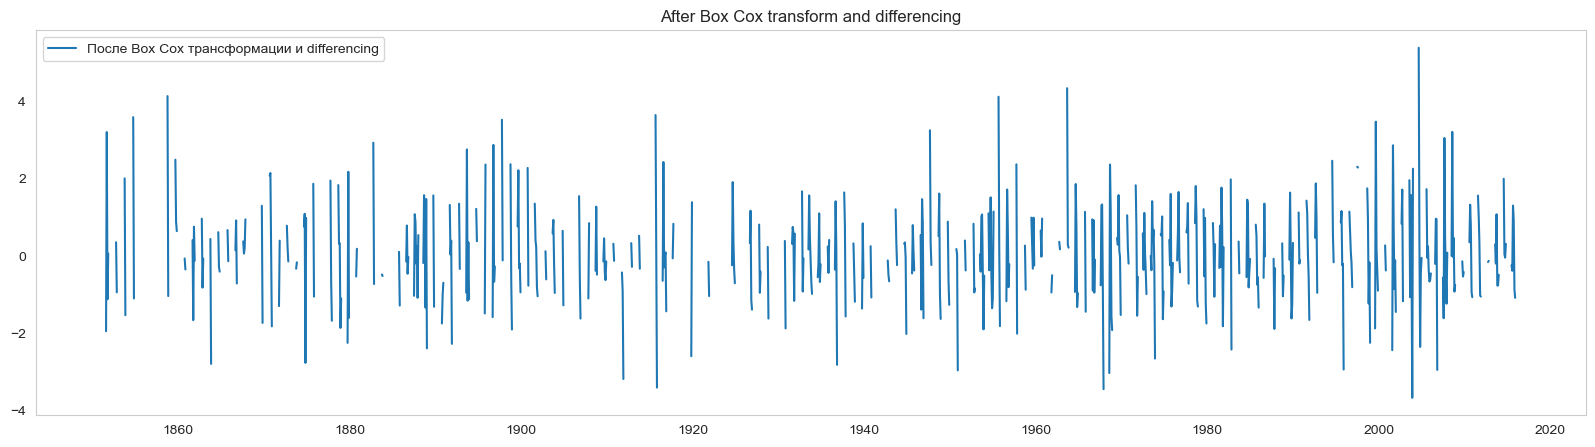

In [60]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
data_boxcox_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
data_boxcox_diff.dropna()
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(data_boxcox_diff, label='После Box Cox трансформации и differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [62]:
def adfuller_test(count):
    result=adfuller(count)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")
    

In [63]:
adfuller_test(data['Minimum Pressure'])

ADF Test Statistic : -4.795589872114697
p-value : 5.545231897361927e-05
#Lags Used : 25
Number of Observations Used : 1948
Data is stationary


In [64]:
kpss_test = kpss(data['Minimum Pressure'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 4.365788
Critical Values @ 0.05: 0.46
p-value: 0.010000


C:\Users\te200\AppData\Local\Temp\ipykernel_17380\3179269312.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(data['Minimum Pressure'])


In [65]:
adfuller_test(data_boxcox_diff)

ADF Test Statistic : -6.5857080639232555
p-value : 7.32398429170946e-09
#Lags Used : 12
Number of Observations Used : 556
Data is stationary


In [66]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.115711
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\te200\AppData\Local\Temp\ipykernel_17380\3639712988.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data_boxcox_diff)


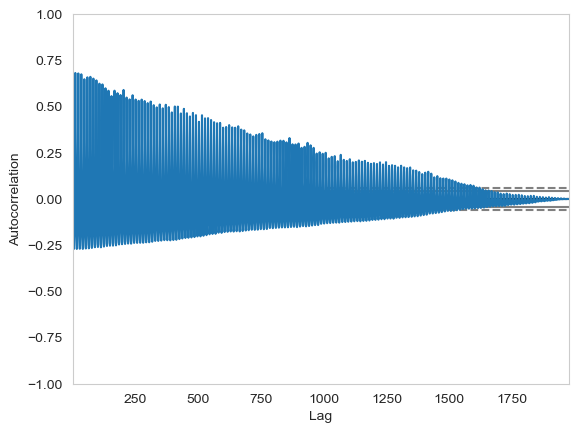

In [67]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Minimum Pressure'])
plt.show()

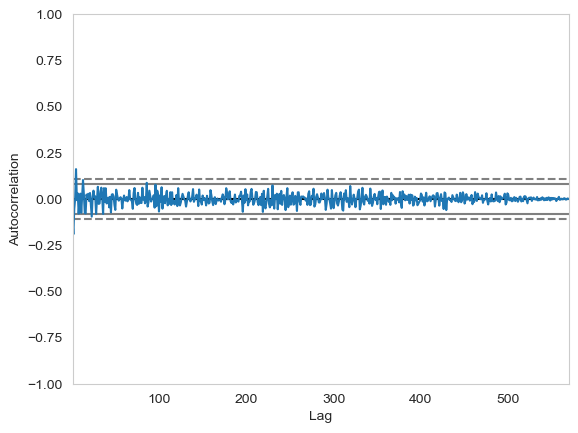

In [68]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data_boxcox_diff)
plt.show()

### Автокорреляция

#### Значение автокорреляции может варьироваться от -1 до 1, аналогично коэффициенту корреляции:

1) Положительное значение автокорреляции указывает на наличие последовательности схожих значений, то есть на сильную связь между каждым элементом и предшествующими ему элементами.
2) Отрицательное значение автокорреляции указывает на наличие последовательности сменяющихся значений, то есть на сильную связь между каждым элементом и предшествующими ему элементами с обратной зависимостью.
3) Значение автокорреляции равное нулю означает отсутствие автокорреляции.

        Важно также учитывать лаговый интервал, который показывает, насколько далеко текущее значение связано со значениями в предыдущих периодах.

In [69]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

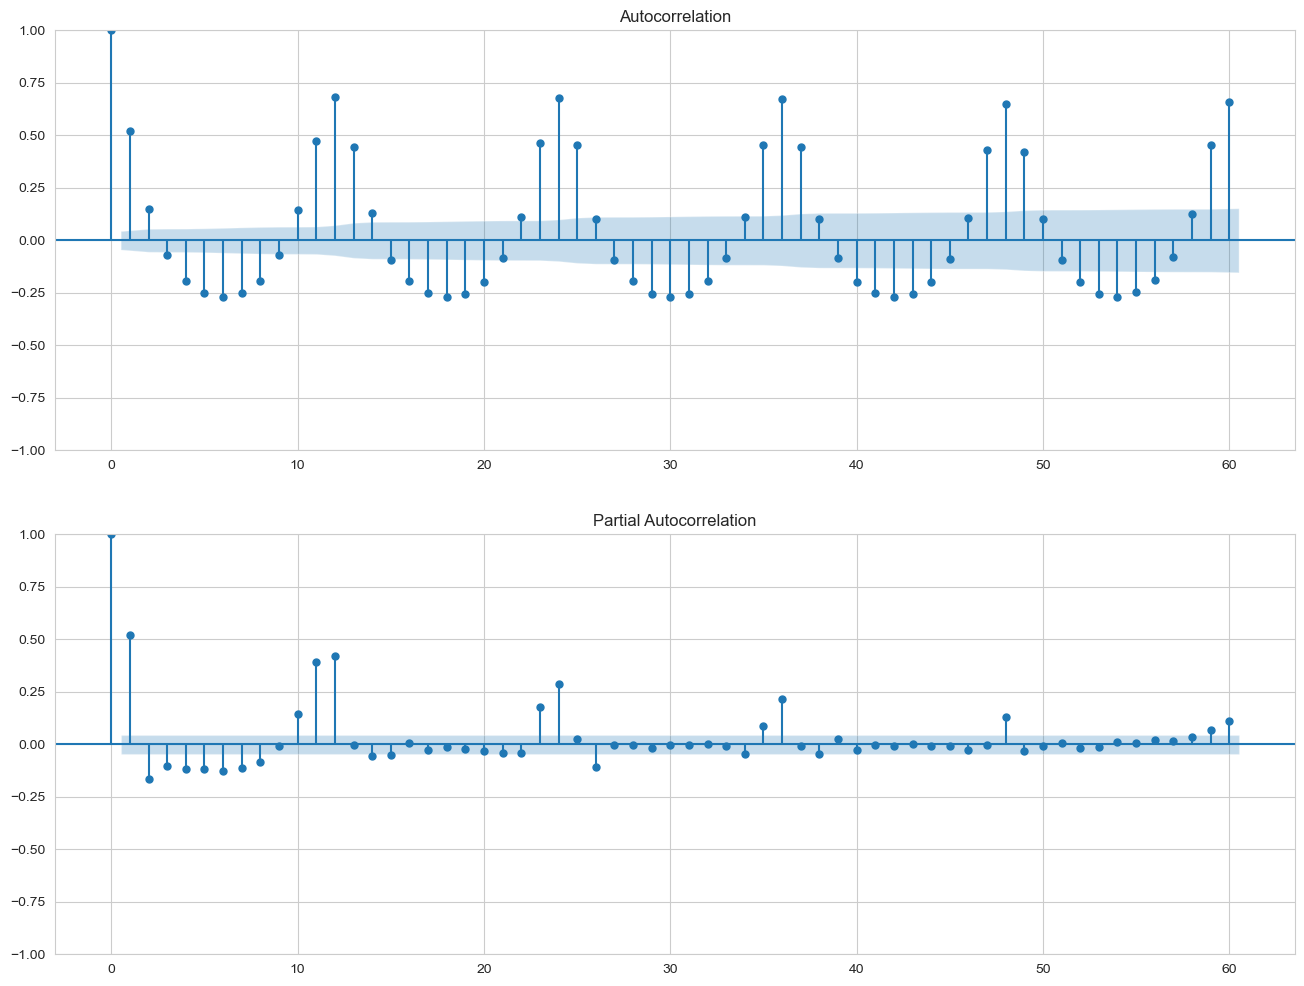

In [70]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Minimum Pressure'],lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Minimum Pressure'],lags=60, ax=ax2)

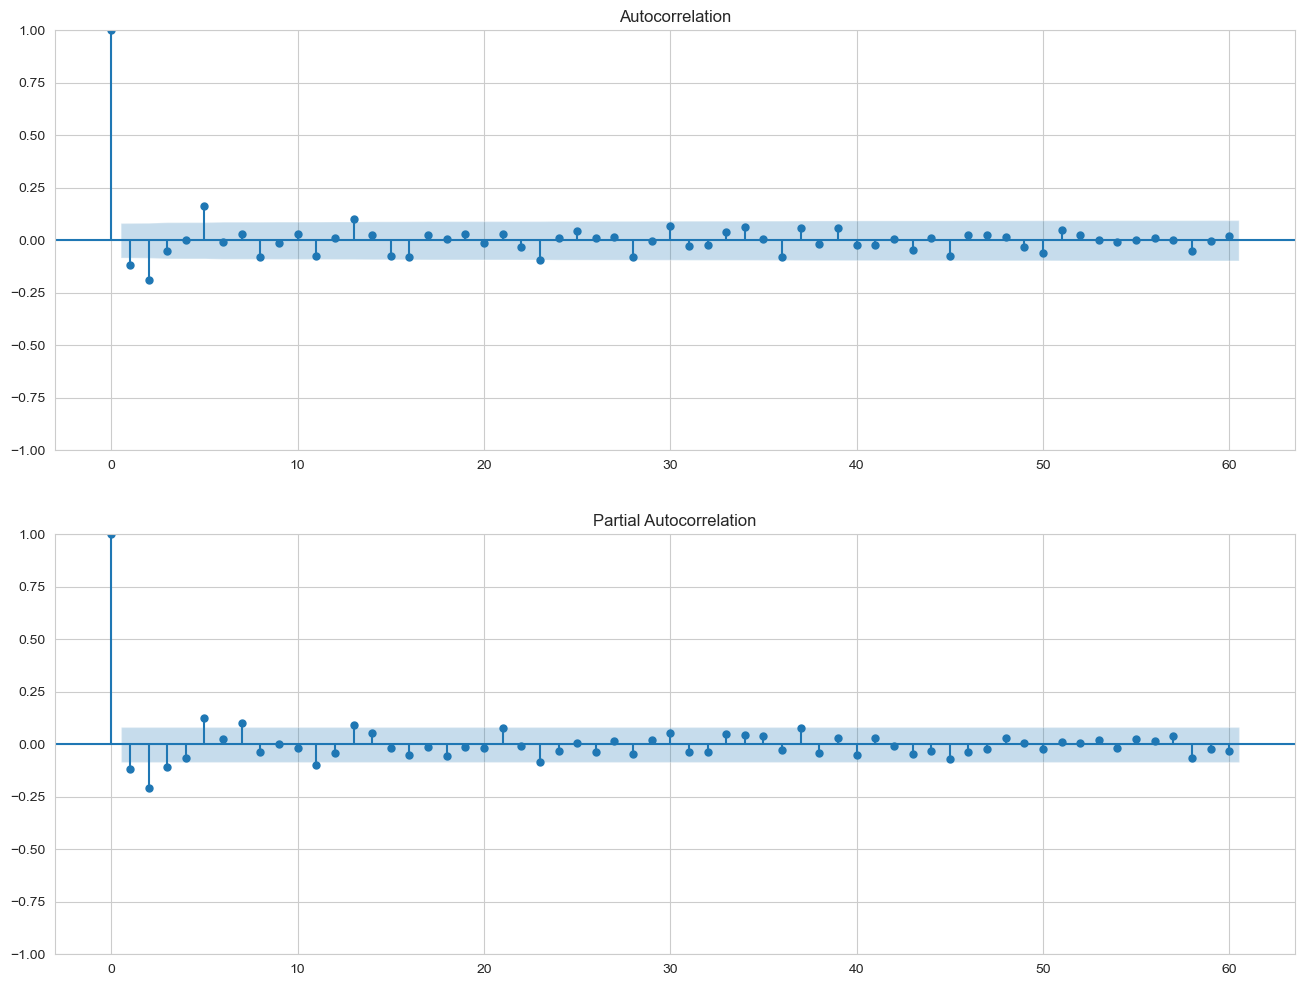

In [71]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_boxcox_diff,lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_boxcox_diff,lags=60, ax=ax2)

In [72]:
from statsmodels.tsa.arima.model import ARIMA

In [73]:
model_1=ARIMA(data['Minimum Pressure'],order=(1,1,1), seasonal_order=(1, 1, 1, 12))
model_1_fit=model_1.fit()
model_2=ARIMA(data['Minimum Pressure'],order=(2,1,0), seasonal_order=(1, 1, 1, 12))
model_2_fit=model_2.fit()

In [74]:
model_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                 Minimum Pressure   No. Observations:                 1974
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -9247.055
Date:                          Thu, 08 Feb 2024   AIC                          18504.109
Time:                                  03:39:50   BIC                          18532.015
Sample:                              06-30-1851   HQIC                         18514.366
                                   - 11-30-2015                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2171      0.014     15.873      0.000       0.190       0.244
ma.L1         -0.9999      0.026    -38.552      0.000      -1.051      -0.949
ar.S.L12       0.0103      0.015      0.670      0.503      -0.020       0.040
ma.S.L12      -0.9213      0.006   -154.070      0.000      -0.933      -0.910
sigma2       717.3604     23.221     30.893      0.000     671.849     762.872
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              5873.52
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Minimum Pressure   No. Observations:                 1974
Model:             ARIMA(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -9452.767
Date:                            Thu, 08 Feb 2024   AIC                          18915.534
Time:                                    03:39:50   BIC                          18943.440
Sample:                                06-30-1851   HQIC                         18925.791
                                     - 11-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5462      0.015    -37.643      0.000      -0.575      -0.518
ar.L2         -0.2727      0.015    -18.070      0.000      -0.302      -0.243
ar.S.L12      -0.0159      0.017     -0.913      0.361      -0.050       0.018
ma.S.L12      -0.9174      0.007   -132.065      0.000      -0.931      -0.904
sigma2       890.0348     15.533     57.301      0.000     859.592     920.478
===================================================================================
Ljung-Box (L1) (Q):                   5.40   Jarque-Bera (JB):              2474.38
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

<Axes: xlabel='Datetime', ylabel='Minimum Pressure'>

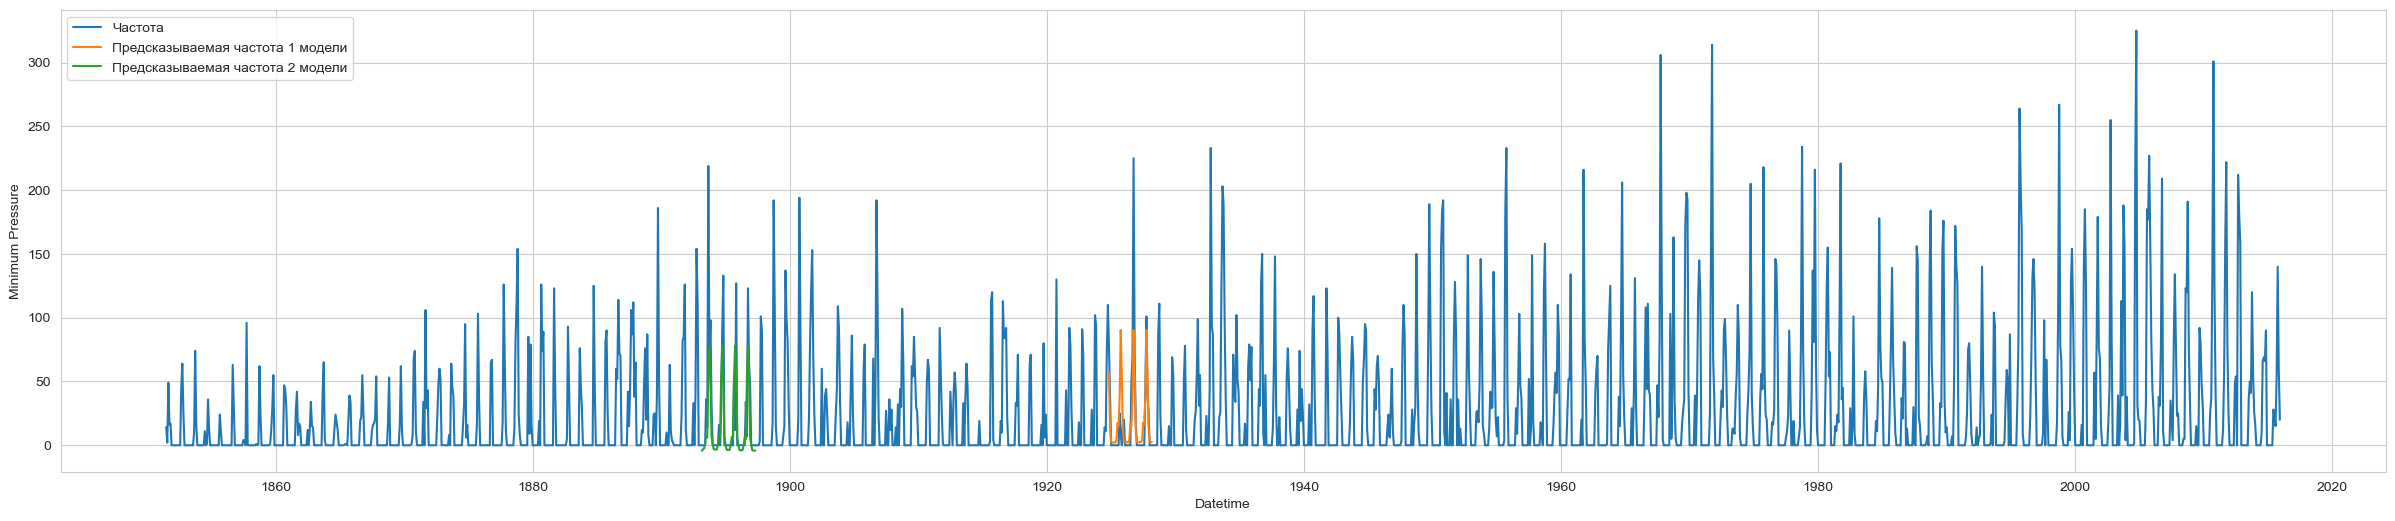

In [76]:
data['forecast_1']=model_1_fit.predict(start=880,end=920,dynamic=True)
data['forecast_2']=model_2_fit.predict(start=500,end=550,dynamic=True)
plt.figure(figsize= (30,6))
sns.lineplot(x = data.index, y = 'Minimum Pressure' , data = data , label = 'Частота')
sns.lineplot(x = data.index, y = 'forecast_1' , data = data , label = 'Предсказываемая частота 1 модели')
sns.lineplot(x = data.index, y = 'forecast_2' , data = data , label = 'Предсказываемая частота 2 модели')

In [77]:
model = SARIMAX(data['Minimum Pressure'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

In [78]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Minimum Pressure   No. Observations:                 1974
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -9247.055
Date:                            Thu, 08 Feb 2024   AIC                          18504.109
Time:                                    03:40:31   BIC                          18532.015
Sample:                                06-30-1851   HQIC                         18514.366
                                     - 11-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2171      0.014     15.873      0.000       0.190       0.244
ma.L1         -0.9999      0.026    -38.552      0.000      -1.051      -0.949
ar.S.L12       0.0103      0.015      0.670      0.503      -0.020       0.040
ma.S.L12      -0.9213      0.006   -154.070      0.000      -0.933      -0.910
sigma2       717.3604     23.221     30.893      0.000     671.849     762.872
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              5873.52
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
from datetime import timedelta

In [85]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,600)]

In [86]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

In [88]:
future_datest_df

,Minimum Pressure,forecast_1,forecast_2
2015-12-30,NaN,NaN,NaN
2016-01-30,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN
2016-03-30,NaN,NaN,NaN
2016-04-30,NaN,NaN,NaN
...,...,...,...
2065-06-30,NaN,NaN,NaN
2065-07-30,NaN,NaN,NaN
2065-08-30,NaN,NaN,NaN
2065-09-30,NaN,NaN,NaN


In [89]:
future_df = pd.concat([data,future_datest_df])

C:\Users\te200\AppData\Local\Temp\ipykernel_17380\2405087247.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([data,future_datest_df])


In [90]:
future_df

,Minimum Pressure,forecast_1,forecast_2
1851-06-30,14,NaN,NaN
1851-07-31,2,NaN,NaN
1851-08-31,49,NaN,NaN
1851-09-30,16,NaN,NaN
1851-10-31,17,NaN,NaN
...,...,...,...
2065-06-30,NaN,NaN,NaN
2065-07-30,NaN,NaN,NaN
2065-08-30,NaN,NaN,NaN
2065-09-30,NaN,NaN,NaN


In [91]:
future_df=pd.concat([data,future_datest_df])

C:\Users\te200\AppData\Local\Temp\ipykernel_17380\2841799880.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([data,future_datest_df])


C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

<Axes: ylabel='Minimum Pressure'>

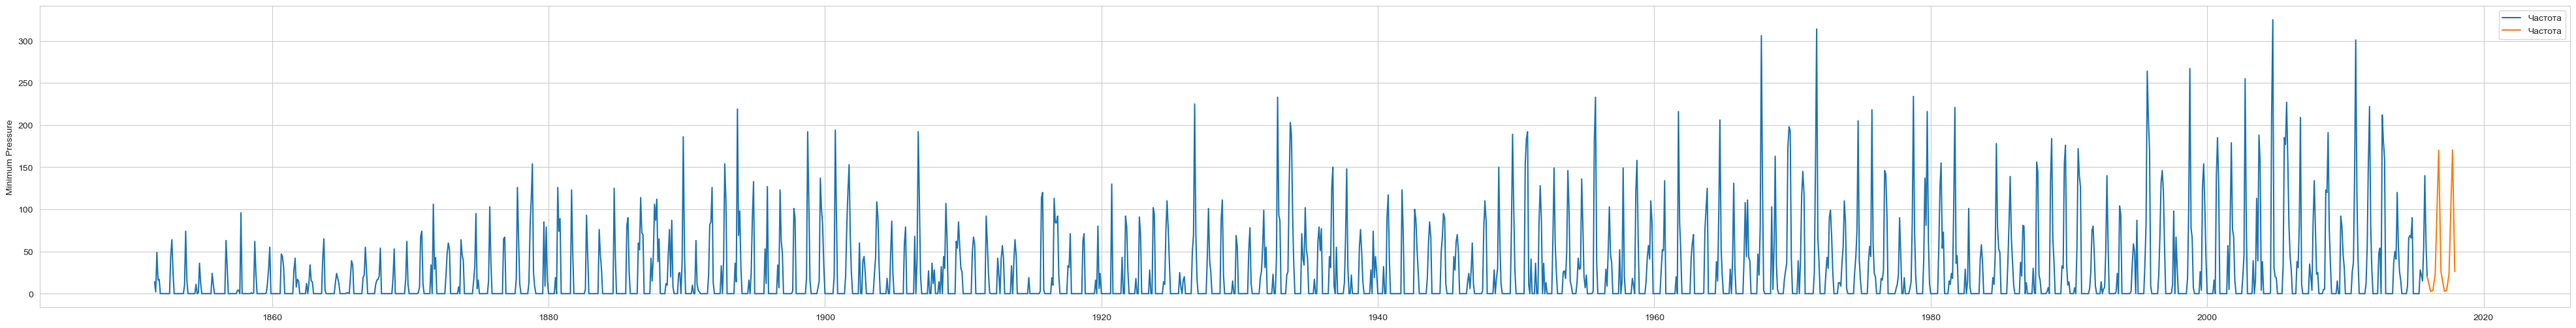

In [92]:
future_df['forecast1']=model_fit.predict(start=1973,end=1998,dynamic=True)
plt.figure(figsize= (50,6))
sns.lineplot(x = future_df.index, y = 'Minimum Pressure' , data = future_df , label = 'Частота')
sns.lineplot(x = future_df.index, y = 'forecast1' , data = future_df , label = 'Частота')

In [93]:
model_fit.predict(1963,1974,dynamic=True)

2015-01-31      1.597777
2015-02-28      2.112703
2015-03-31      2.487048
2015-04-30      4.094145
2015-05-31      9.119577
2015-06-30     22.767586
2015-07-31     45.913287
2015-08-31    111.983730
2015-09-30    171.533303
2015-10-31     84.757776
2015-11-30     26.039419
2015-12-31      9.535399
Freq: M, Name: predicted_mean, dtype: float64

<Axes: >

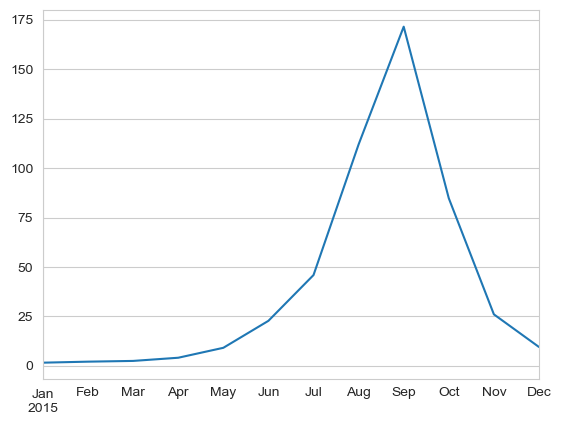

In [95]:
model_fit.predict(1963,1974,dynamic=True).plot()

In [94]:
model_fit.save('file')

from statsmodels.tsa.arima.model import ARIMAResults
results_ = ARIMAResults.load('file')

In [96]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [97]:
print(device)

cuda:0


In [98]:
df

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
Datetime,,,,,,,,,,,,,,,,,,,,
1851-06-25 00:00:00,AL011851,UNNAMED,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 06:00:00,AL011851,UNNAMED,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 12:00:00,AL011851,UNNAMED,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 18:00:00,AL011851,UNNAMED,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 21:00:00,AL011851,UNNAMED,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-12 12:00:00,AL122015,KATE,,EX,41.3N,50.4W,55,981,220,220,180,120,120,120,60,0,0,0,0,0
2015-11-12 18:00:00,AL122015,KATE,,EX,41.9N,49.9W,55,983,220,220,180,120,120,120,60,0,0,0,0,0
2015-11-13 00:00:00,AL122015,KATE,,EX,41.5N,49.2W,50,985,540,520,200,220,120,120,60,0,0,0,0,0


In [99]:
df

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
Datetime,,,,,,,,,,,,,,,,,,,,
1851-06-25 00:00:00,AL011851,UNNAMED,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 06:00:00,AL011851,UNNAMED,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 12:00:00,AL011851,UNNAMED,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 18:00:00,AL011851,UNNAMED,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1851-06-25 21:00:00,AL011851,UNNAMED,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-12 12:00:00,AL122015,KATE,,EX,41.3N,50.4W,55,981,220,220,180,120,120,120,60,0,0,0,0,0
2015-11-12 18:00:00,AL122015,KATE,,EX,41.9N,49.9W,55,983,220,220,180,120,120,120,60,0,0,0,0,0
2015-11-13 00:00:00,AL122015,KATE,,EX,41.5N,49.2W,50,985,540,520,200,220,120,120,60,0,0,0,0,0


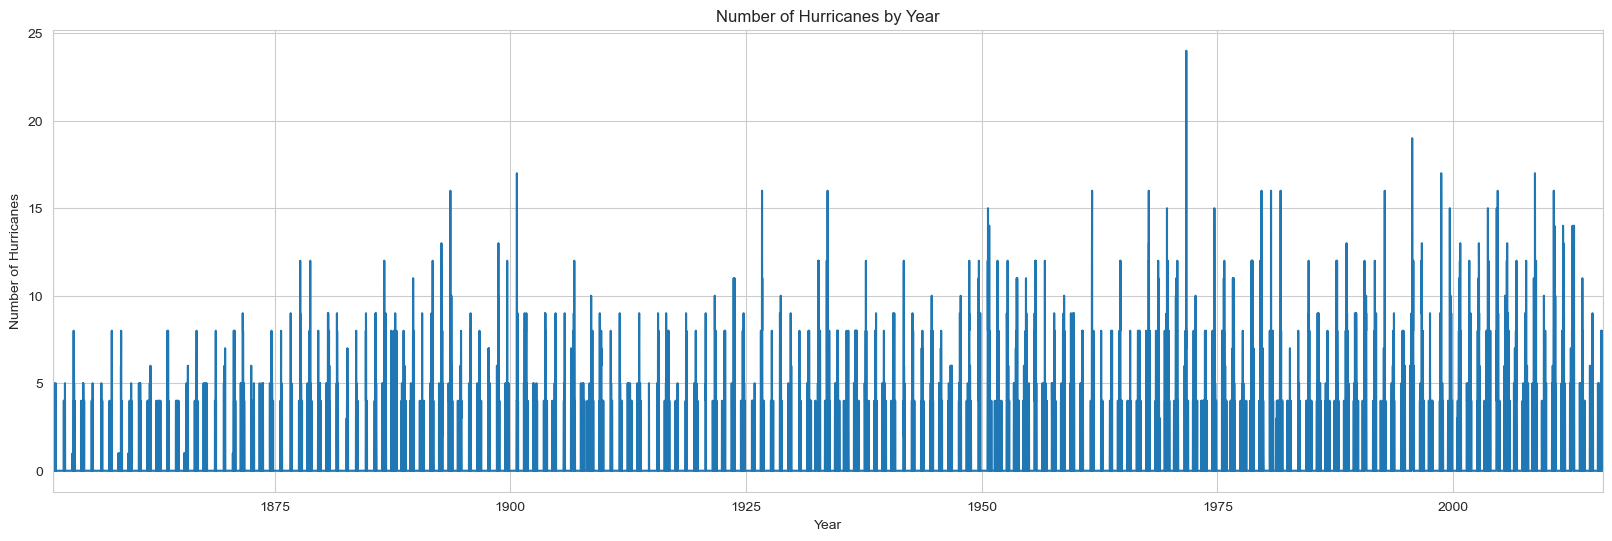

In [100]:
df.resample('D').count()['Minimum Pressure'].plot(figsize=(20, 6))
plt.title('Number of Hurricanes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Hurricanes')
plt.show()

In [101]:
data = pd.DataFrame(df.resample('D').count()['Minimum Pressure'])

In [102]:
data

,Minimum Pressure
Datetime,
1851-06-25,5
1851-06-26,4
1851-06-27,4
1851-06-28,1
1851-06-29,0
...,...
2015-11-09,4
2015-11-10,4
2015-11-11,4


In [103]:
future = (data.index + timedelta(days=18250)).strftime("%Y-%m-%d")

In [104]:
future

Index(['1901-06-13', '1901-06-14', '1901-06-15', '1901-06-16', '1901-06-17',
       '1901-06-18', '1901-06-19', '1901-06-20', '1901-06-21', '1901-06-22',
       ...
       '2065-10-22', '2065-10-23', '2065-10-24', '2065-10-25', '2065-10-26',
       '2065-10-27', '2065-10-28', '2065-10-29', '2065-10-30', '2065-10-31'],
      dtype='object', name='Datetime', length=60042)

In [105]:
future_dates_df=pd.DataFrame(index=future,columns=['Minimum Pressure'])

In [114]:
future_dates_df = future_dates_df.tail(600).fillna(0)

In [115]:
data.index

DatetimeIndex(['1851-06-25', '1851-06-26', '1851-06-27', '1851-06-28',
               '1851-06-29', '1851-06-30', '1851-07-01', '1851-07-02',
               '1851-07-03', '1851-07-04',
               ...
               '2015-11-04', '2015-11-05', '2015-11-06', '2015-11-07',
               '2015-11-08', '2015-11-09', '2015-11-10', '2015-11-11',
               '2015-11-12', '2015-11-13'],
              dtype='datetime64[ns]', name='Datetime', length=60042, freq='D')

In [116]:
future_dates_df.index

Index(['2064-03-11', '2064-03-12', '2064-03-13', '2064-03-14', '2064-03-15',
       '2064-03-16', '2064-03-17', '2064-03-18', '2064-03-19', '2064-03-20',
       ...
       '2065-10-22', '2065-10-23', '2065-10-24', '2065-10-25', '2065-10-26',
       '2065-10-27', '2065-10-28', '2065-10-29', '2065-10-30', '2065-10-31'],
      dtype='object', name='Datetime', length=600)

In [117]:
future_df = pd.concat([data,future_dates_df])

In [118]:
future_df

,Minimum Pressure
Datetime,
1851-06-25 00:00:00,5
1851-06-26 00:00:00,4
1851-06-27 00:00:00,4
1851-06-28 00:00:00,1
1851-06-29 00:00:00,0
...,...
2065-10-27,0
2065-10-28,0
2065-10-29,0


In [119]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    
    for i in range(1, n_steps+1):
        df[f'Minimum Pressure(t-{i})'] = df['Minimum Pressure'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(future_df, lookback)
shifted_df

,Minimum Pressure,Minimum Pressure(t-1),Minimum Pressure(t-2),Minimum Pressure(t-3),Minimum Pressure(t-4),Minimum Pressure(t-5),Minimum Pressure(t-6),Minimum Pressure(t-7)
Datetime,,,,,,,,
1851-07-02 00:00:00,0,0.0,0.0,0.0,1.0,4.0,4.0,5.0
1851-07-03 00:00:00,0,0.0,0.0,0.0,0.0,1.0,4.0,4.0
1851-07-04 00:00:00,0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1851-07-05 00:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1851-07-06 00:00:00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2065-10-27,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2065-10-28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2065-10-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[0., 0., 0., ..., 4., 4., 5.],
       [0., 0., 0., ..., 1., 4., 4.],
       [0., 0., 0., ..., 0., 1., 4.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:
shifted_df_as_np.shape

(60635, 8)

In [122]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -1.        , -1.        , ..., -0.66666667,
        -0.66666667, -0.58333333],
       [-1.        , -1.        , -1.        , ..., -0.91666667,
        -0.66666667, -0.66666667],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -0.91666667, -0.66666667],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [123]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((60635, 7), (60635,))

In [126]:
X = dc(np.flip(X, axis=1))
X

array([[-0.58333333, -0.66666667, -0.66666667, ..., -1.        ,
        -1.        , -1.        ],
       [-0.66666667, -0.66666667, -0.91666667, ..., -1.        ,
        -1.        , -1.        ],
       [-0.66666667, -0.91666667, -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [127]:
X_train = X[:int(len(X) * 0.60)]
X_test = X[int(len(X) * 0.60):int(len(X) * 0.76)]
X_future = X[int(len(X) * 0.76):]

y_train = y[:int(len(X) * 0.60)]
y_test = y[int(len(X) * 0.60):int(len(X) * 0.76)]
y_future = y[int(len(X) * 0.76):]

X_train.shape, X_test.shape, X_future.shape, y_train.shape, y_test.shape, y_future.shape

((36381, 7), (9701, 7), (14553, 7), (36381,), (9701,), (14553,))

In [128]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
X_future = X_future.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_future = y_future.reshape((-1, 1))

X_train.shape, X_test.shape, X_future.shape, y_train.shape, y_test.shape, y_future.shape

((36381, 7, 1), (9701, 7, 1), (14553, 7, 1), (36381, 1), (9701, 1), (14553, 1))

In [129]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_future = torch.tensor(X_future).float()
y_future = torch.tensor(y_future).float()

X_train.shape, X_test.shape, X_future.shape, y_train.shape, y_test.shape, y_future.shape

(torch.Size([36381, 7, 1]),
 torch.Size([9701, 7, 1]),
 torch.Size([14553, 7, 1]),
 torch.Size([36381, 1]),
 torch.Size([9701, 1]),
 torch.Size([14553, 1]))

In [130]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X: torch.tensor, y: torch.tensor):
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, i: int) -> tuple:
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
future_dataset = TimeSeriesDataset(X_future, y_future)

In [131]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
future_loader = DataLoader(future_dataset, batch_size=batch_size, shuffle=False)

In [132]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 7, 1]) torch.Size([32, 1])


In [133]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_stacked_layers: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x) -> torch.tensor:
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [146]:
import wandb

In [147]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: te200228. Use `wandb login --relogin` to force relogin


In [157]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            wandb.log({'Loss': avg_loss_across_batches})
            running_loss = 0.0
    print()

In [158]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    wandb.log({'Val Loss': avg_loss_across_batches})

In [159]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10



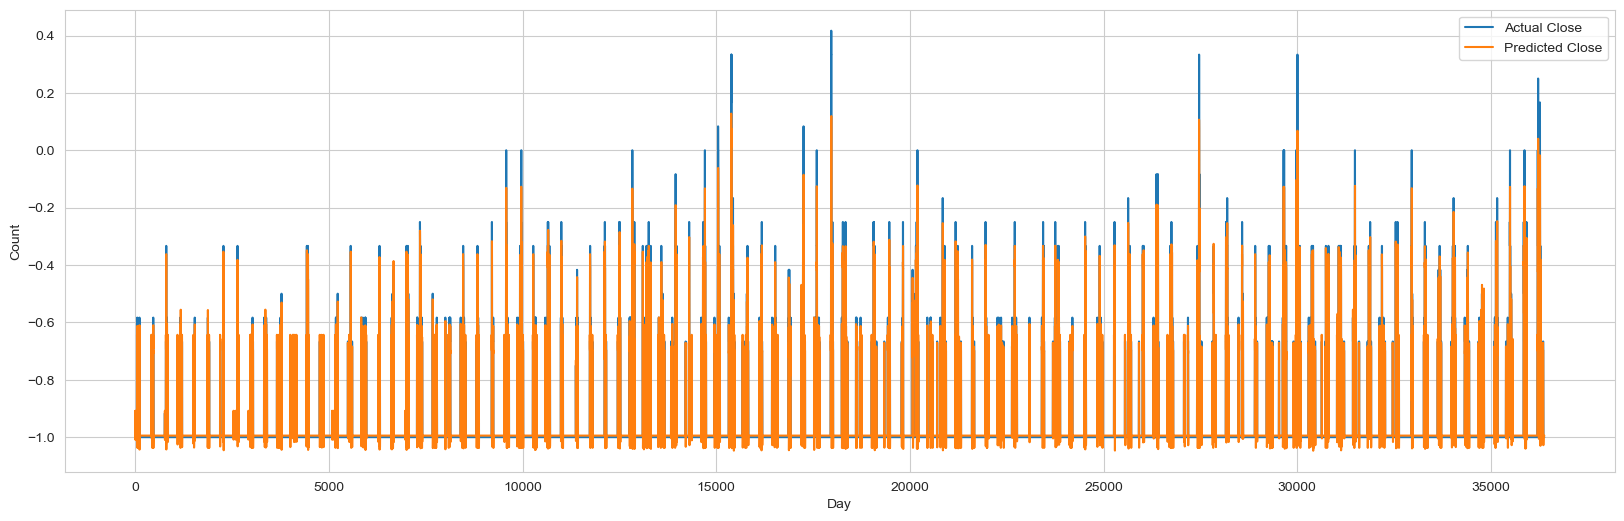

In [137]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
plt.figure(figsize= (20,6))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend()
plt.show()


In [138]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([0.06491375, 0.06491375, 0.06491375, ..., 0.06491375, 2.15805602,
       3.94726896])

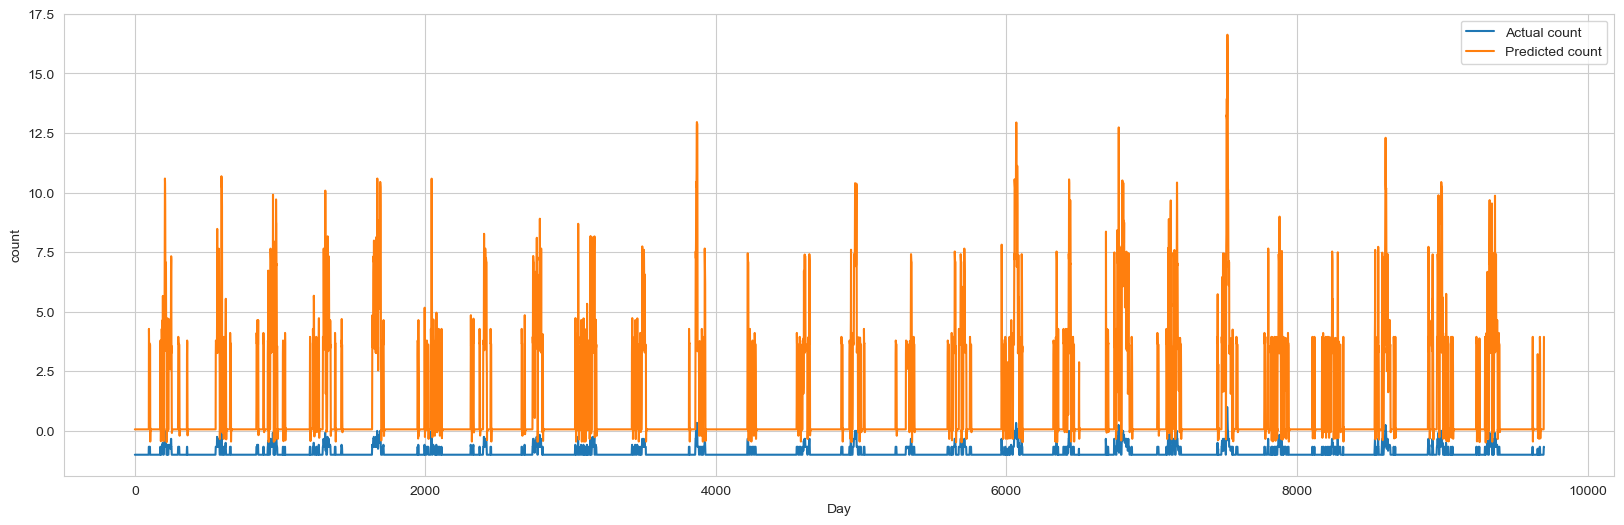

In [141]:
plt.figure(figsize= (20,6))
plt.plot(y_test, label='Actual count')
plt.plot(test_predictions, label='Predicted count')
plt.xlabel('Day')
plt.ylabel('count')
plt.legend()
plt.show()

In [144]:
future_predictions = model(X_future.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_future.shape[0], lookback+1))
dummies[:, 0] = future_predictions
dummies = scaler.inverse_transform(dummies)

future_predictions = dc(dummies[:, 0])
future_predictions

array([3.67910957, 3.67421579, 3.63821197, ..., 0.06491375, 0.06491375,
       0.06491375])

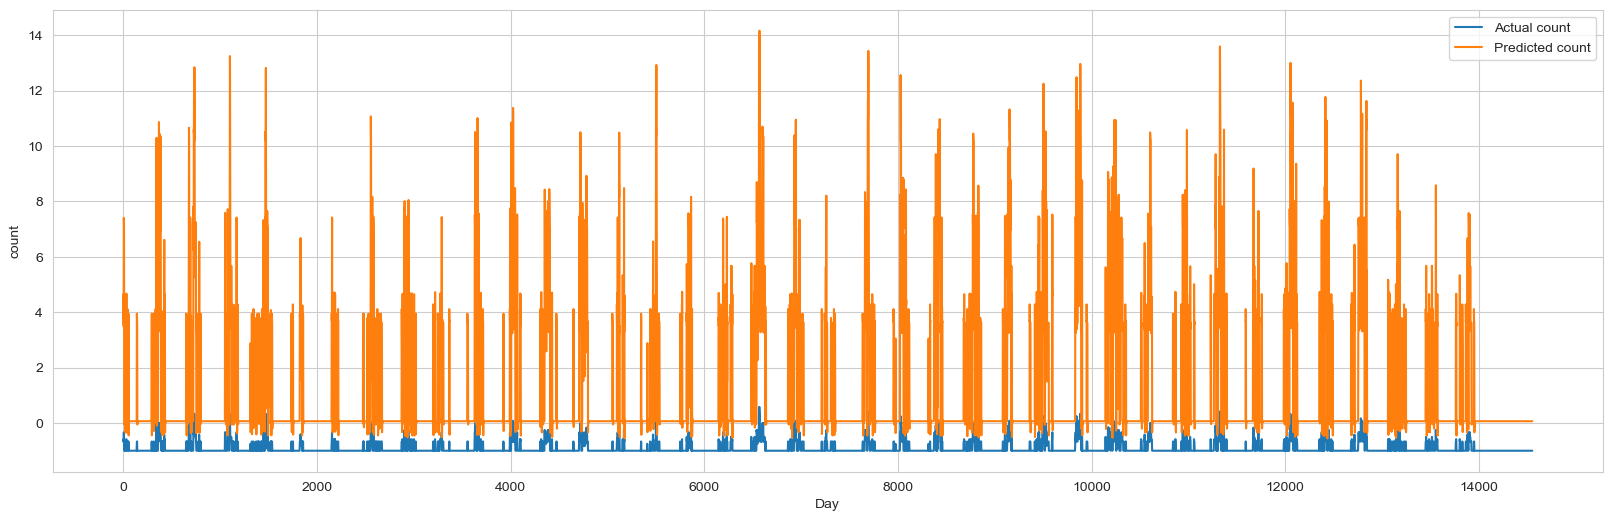

In [145]:
plt.figure(figsize= (20,6))
plt.plot(y_future, label='Actual count')
plt.plot(future_predictions, label='Predicted count')
plt.xlabel('Day')
plt.ylabel('count')
plt.legend()
plt.show()